<a href="https://colab.research.google.com/github/rsmarinho/pdscodes/blob/master/TP07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

**TP08 - Processamento Digital de Imagens.**

---

O processamento digital de imagens é feito em duas dimensões, na dimensão *x* (colunas) e na dimensão *y* (linhas). Podemos considerar que uma linha/coluna é um sinal unidimensional e processar cada linha como um sinal unidimensional (em tons de cinza), como um sinal de audio, por exemplo.

Procedimentos como filtragem, compactação, quantização podem ser considerados também como processamento de imagens. Cada amostra da imagem é chamada de pixel e a *densidade de píxels* pode ser considerada como uma boa analogia ao período de amostragem do sinal.

Imagens coloridas implicam em diferentes graus de complexidade no processamento de imagens, e a utilização de diferentes [modelo de cores](https://en.wikipedia.org/wiki/Color_model) pode auxiliar no  processamento. Aqui utilizaremos apenas imagens preto e branco e coloridas no modelo de cor [RGB](https://en.wikipedia.org/wiki/RGB_color_model).

float32
(512, 512, 3)
<class 'numpy.ndarray'>
[[[226. 137. 125.]
  [226. 137. 125.]
  [223. 137. 133.]]

 [[226. 137. 125.]
  [226. 137. 125.]
  [223. 137. 133.]]

 [[226. 137. 125.]
  [226. 137. 125.]
  [223. 137. 133.]]]


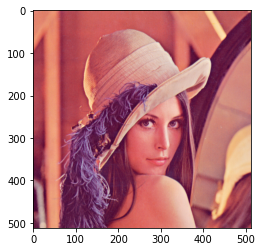

In [2]:
# funcao matplotlib que le imagem lena512.png e carrega em
# uma matriz RGB tridimensional [512,512,3]
img = image.imread('/content/lena512.png')

# algumas funcoes que podem auxiliar no programa, é sempre
# bom conhecer algumas informações sobre o arquivo que está
# sendo carregado

print(img.dtype)
print(img.shape)
print(type(img))

# o arquivo carregado têm os valores de amplitude do tipo
# float32 que variam entre 0..1, para transformá-los em inteiros
# basta proceder com a operação abaixo.
print(np.floor(img[:3,:3]*255))

# função que transforma uma imagem RGB em uma imagem p&b.
# A função é uma combinação linear (produto interno) de
# cada um dos valores R, G e B com o vetor [0.2989, 0.5870, 0.1140]
# https://www.mathworks.com/help/matlab/ref/rgb2gray.html
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

plt.imshow(img)

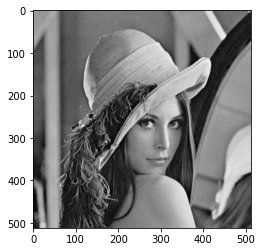

In [3]:
imgbw = rgb2gray(img)

# lembre-se de utilizar o mapa de cores correto para
# visualizar o tipo de imagem que você tem. Experimente
# utilizar outros mapas de cores para obter outros
# efeitos de visualização.
plt.imshow(imgbw, cmap=plt.get_cmap('gray'))

In [4]:
# Em processamento de imagem geralmente utiliza-se a tranformada coseno
# discreto ao invés da transformada de Fourier, por motivos dentre os 
# quais a DCT é melhor adaptada para aplicações de compressão. A DCT
# é uma transformada relacionada à transformada de Fourier (Fourier-related)
# Mais informações sobre a DCT pode ser encontrada em
# https://en.wikipedia.org/wiki/Discrete_cosine_transform

# Aqui definimos as funções DCT de tipo II e III, essas funções são operações
# inversas uma da outra. Ou seja, a DCTIII é a transformada inversa da DCTII
# e vice-e-versa

def dctII(x):
  N = len(x)

  n = np.linspace(0, N-1, N)
  e = lambda f: np.cos((np.pi/N) * (n + 0.5) * f)
  
  ft = np.zeros((N, N))
  for k in range(N):
    ft[:, k] = e(k) * x

  return np.sum(ft, axis=0)

def idctIII(x):
  N = len(x)

  n = np.linspace(0, N-1, N)
  e = lambda f: np.cos((np.pi/N) * (f + 0.5) * n)
  
  ft = np.zeros((N, N))
  for k in range(N):
    ft[:, k] = e(k) * x
    ft[0, k] = x[0] * 0.5

  return np.sum(ft, axis=0)

In [5]:
# Quantidade de samples utilizados para representação da imagem original
# quanto menos samples, maior a compactação da imagem. Como a imagem lena
# tem tamanho de 512x512, utilizar 254 samples significa uma compactação de 25%.

# samples = int(np.floor(len(imgbw[0]) / 2)) # uses 256 samples for row/column
# samples = int(np.floor(len(imgbw[0]) / 4)) # uses 128 samples for row/column
samples = int(np.floor(len(imgbw[0]) / 8)) # uses 64 samples for row/column

In [6]:
# O processo de compactação de imagem segue da seguinte forma:
# 1. Calculo da DCT da imagem nos dois eixos (linha e coluna)
# 2. Remove frequencias altas (com baixo nivel de energia)
# 3. Calcula a IDCT para obter a imagem final

# as variáveis abaixo são utilizadas para que cada fase do processo possa
# ser visualizada, assim podemos ter uma idéia melhor do passo a passo
# descrito acima.
img_aux = np.zeros(imgbw.shape) # imagem original
DCT = np.zeros(imgbw.shape)     # imagem DCT
ci = np.zeros(imgbw.shape)      # imagem final compactada

aux = np.zeros(imgbw.shape)     # matriz intermediario para calculo dct 
aux2 = np.zeros(imgbw.shape)    # matriz intermediario calculo idct

# DCT
for i in range(0, 512):
  img_aux[i, :] = dctII(imgbw[i, :])
for j in range(0, 512):
  DCT[:, j] = dctII(img_aux[:, j])

# IDCT
for i in range(0, 512):
  aux[i, 0:samples] = DCT[i, 0:samples]
  aux[i, :] = idctIII(aux[i, :])

for j in range(0, 512):
  aux2[0:samples, j] = aux[0:samples, j]
  ci[:, j] = idctIII(aux2[:, j])

In [7]:
# Outra maneira de zerar índices menos importantes da imagem é utilizando uma
# função de threshold. Em python podemos utilizar as facilidades da linguagem
# E gerar o mapeamento de índices dos valores da matriz que são menores ou 
# maiores do que determinado valor facilmente

thresh = 0.01
dct_thresh = DCT * (abs(DCT) > (thresh*np.max(DCT)))
# print(DCT[0:20] * dct_thresh[0:20])

percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imgbw.shape[0]*imgbw.shape[1]*1.0)
print("Mantém apenas %f%% dos coeficientes DCT" % (percent_nonzeros*100.0))

abs(DCT[0:8,0:8]) > (thresh*np.max(DCT))

# Esse é apenas um exemplo de como a eliminação de frequências não importantes
# podem ser feitas, seguiremos com a remoção de frequências do caso anterior.
# Ou seja, à partir da eliminação por faixa de frequência.

Mantém apenas 0.025558% dos coeficientes DCT


array([[ True,  True,  True,  True,  True,  True, False,  True],
       [ True,  True,  True, False, False,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False, False,  True,  True, False,  True,  True,  True],
       [ True, False, False, False, False, False, False, False],
       [False, False,  True, False,  True, False,  True,  True],
       [ True, False,  True, False, False, False,  True,  True],
       [ True,  True, False, False, False, False, False,  True]])

In [8]:
# Aqui normalizamos a imagem final para que os termos da matrix também fiquem
# entre 0..1, tal qual a imagem original. Outra maneira mais interessante de
# proceder com a normalização é usando as versões normalizadas da DCT, mas que
# implica em mais operações de calculo e, portanto, mais tempo de execução.
ci=ci/ci.max()

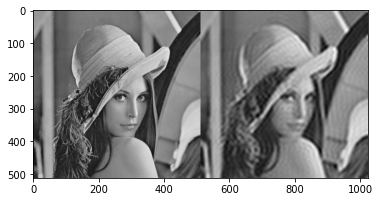

In [9]:
plt.imshow(np.hstack( (imgbw, ci) ), cmap=plt.get_cmap('gray'))

In [10]:
# A função dct que usamos até aqui serve bem para estudo e compreensão, 
# mas é muito lenta. Daqui para frente nesse TP se assegure que o modulo 
# scipy está instalado e utilize as funcoes dct2 e idct2 abaixo. 
# Ambas as funções são interfaces para a função dct do scipy, e que já
# calcula a transformada em duas dimensões.
from scipy.fftpack import dct, idct

def dct2(imgGray, w):
    DCT = dct(dct(imgGray, n=w, axis=0, norm='ortho'), n=w, axis=1, norm='ortho')
    return DCT

def idct2(DCT, w, f):
    IDCT = idct(idct(DCT[0:f,0:f], n=w, axis=0, norm='ortho'), n=w, axis=1, norm='ortho')
    return IDCT

###Questões

---

**1.** Apesar do processo de compactação de imagem ter sido descrito acima, o normal é que a sequência não seja executada na matriz inteira. Antes de que a DCT seja calculada dividimos a matriz em submatrizes menores calculamos a DCT de cada submatriz.

Divida a imagem em várias submatrizes de 8x8 e calcule a DCT de cada submatriz. Para isso não é preciso que submatrizes sejam geradas, você pode fazer isso utilizando indexação da matriz da imagem original. Essa etapa é conhecida como o cálculo dos blocos DCT.

Após calcular as DCT, plote a matriz da DCT.

**2.** Remova (iguale a zero) metade das linhas e colunas de cada bloco DCT. OS blocos DCT deve ser diferente de zero apenas para os índices \[0:4,0:4\] após essa operação.

Quando os blocos DCT for compactado, então calcule a DCT inversa e plote a imagem. Você deve terminar com uma versão compactada da imagem original.


**3.** A compactação JPEG utiliza o mesmo procedimento descrito anteriormente para compactar as imagens. Entretanto, ao invés de remover algumas frequências, esse tipo de compactação utiliza matrizes de quantização para cada nível de compactação. 

Cada índice da matriz DCT compactada é calculado pela equação
$$
C_{i,j}=\mbox{round}\left(\frac{D_{i,j}}{Q_{i,j}}\right)
$$
onde $D_{i,j}$ são os índices da matriz de DCT e $Q_{i,j}$ os índices da matriz de quantização. 

Matrizes de quantização de 10% 50% e 90% estão descritas abaixo. Utilize essas matrizes para compactar a imagem da lena (p&b).

In [11]:
QJPEG10 =[[ 80,  60,  50,  80, 120, 200, 255, 255],
          [ 55,  60,  70,  95, 130, 255, 255, 255],
          [ 70,  65,  80, 120, 200, 255, 255, 255],
          [ 70,  85, 110, 145, 255, 255, 255, 255],
          [ 90, 110, 185, 255, 255, 255, 255, 255],
          [120, 175, 255, 255, 255, 255, 255, 255],
          [245, 255, 255, 255, 255, 255, 255, 255],
          [255, 255, 255, 255, 255, 255, 255, 255]]

QJPEG50 =[[16, 11, 10, 16,  24,  40,  51,  61],
          [12, 12, 14, 19,  26,  58,  60,  55],
          [14, 13, 16, 24,  40,  57,  69,  56],
          [14, 17, 22, 29,  51,  87,  80,  62],
          [18, 22, 37, 56,  68, 109, 103,  77],
          [24, 35, 55, 64,  81, 104, 113,  92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103,  99]]

QJPEG90 =[[3,   2,  2,  3,  5,  8, 10, 12],
          [2,   2,  3,  4,  5, 12, 12, 11],
          [3,   3,  3,  5,  8, 11, 14, 11],
          [3,   3,  4,  6, 10, 17, 16, 12],
          [4,   4,  7, 11, 14, 22, 21, 15],
          [5,   7, 11, 13, 16, 12, 23, 18],
          [10, 13, 16, 17, 21, 24, 24, 21],
          [14, 18, 19, 20, 22, 20, 20, 20]]

**4.** Faça o mesmo procedimento da questão anterior, agora para a imagem lena original (colorida).